<a href="https://colab.research.google.com/github/Roopesh-DMahanthi/Image_Super_Resolution/blob/master/Image_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 51kB/s 


In [2]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.3.0


## Build the Encoder

In [3]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l4 = Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img,l7)

In [4]:
encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)      

## Build the Decoder

In [5]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l4 = Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6)


In [25]:
l8 = UpSampling2D()(l7)
l9 = Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11 = add([l5,l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = add([l14,l2])
decoded = Conv2D(3,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l5)
autoencoder = Model(input_img,decoded)
autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 3)      

In [7]:
autoencoder.compile(optimizer='adadelta',loss='mean_squared_error')

## Create Dataset and Specify Training Routine

In [9]:
!wget "http://imagenet.stanford.edu/internal/car196/cars_test.tgz"

--2020-09-03 12:04:35--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M   817KB/s    in 89s     

2020-09-03 12:06:05 (10.5 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [10]:
!tar zxvf cars_test.tgz

Streaming output truncated to the last 5000 lines.
cars_test/03043.jpg
cars_test/03044.jpg
cars_test/03045.jpg
cars_test/03046.jpg
cars_test/03047.jpg
cars_test/03048.jpg
cars_test/03049.jpg
cars_test/03050.jpg
cars_test/03051.jpg
cars_test/03052.jpg
cars_test/03053.jpg
cars_test/03054.jpg
cars_test/03055.jpg
cars_test/03056.jpg
cars_test/03057.jpg
cars_test/03058.jpg
cars_test/03059.jpg
cars_test/03060.jpg
cars_test/03061.jpg
cars_test/03062.jpg
cars_test/03063.jpg
cars_test/03064.jpg
cars_test/03065.jpg
cars_test/03066.jpg
cars_test/03067.jpg
cars_test/03068.jpg
cars_test/03069.jpg
cars_test/03070.jpg
cars_test/03071.jpg
cars_test/03072.jpg
cars_test/03073.jpg
cars_test/03074.jpg
cars_test/03075.jpg
cars_test/03076.jpg
cars_test/03077.jpg
cars_test/03078.jpg
cars_test/03079.jpg
cars_test/03080.jpg
cars_test/03081.jpg
cars_test/03082.jpg
cars_test/03083.jpg
cars_test/03084.jpg
cars_test/03085.jpg
cars_test/03086.jpg
cars_test/03087.jpg
cars_test/03088.jpg
cars_test/03089.jpg
cars_test

In [23]:
def train_batches(just_load_dataset=False):

    batches = 256 

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("cars_test"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(resize(rescale(rescale(image_resized, 0.5), 2.0),(256,256,3)))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

In [14]:
image = pyplot.imread('cars_test/08023.jpg')

In [16]:
image_resized = resize(image, (256, 256))

In [17]:
image_resized.shape

(256, 256, 3)

In [22]:
resize(rescale(rescale(image_resized, 0.5), 2.0),(256,256,3)).shape

(256, 256, 3)

## Load the Dataset and Train Model

In [24]:
x_train_n, x_train_down = train_batches(just_load_dataset=False)

Training batch 1 ( 256 )
Epoch 1/4


ValueError: ignored

In [ ]:
autoencoder.load_weights('auto_encoder_model.hdf5')

## Model Predictions and Visualizing the Results

In [ ]:
encoder.load_weights('encoder_weights.hdf5')

In [ ]:
encoded_imgs = encoder.predict(x_train_down)

In [ ]:
encoded_imgs.shape

(256, 64, 64, 256)

In [ ]:
sr1 = np.clip(autoencoder.predict(x_train_down),0.0,1.0)

In [ ]:
image_index = np.random.randint(0,256)

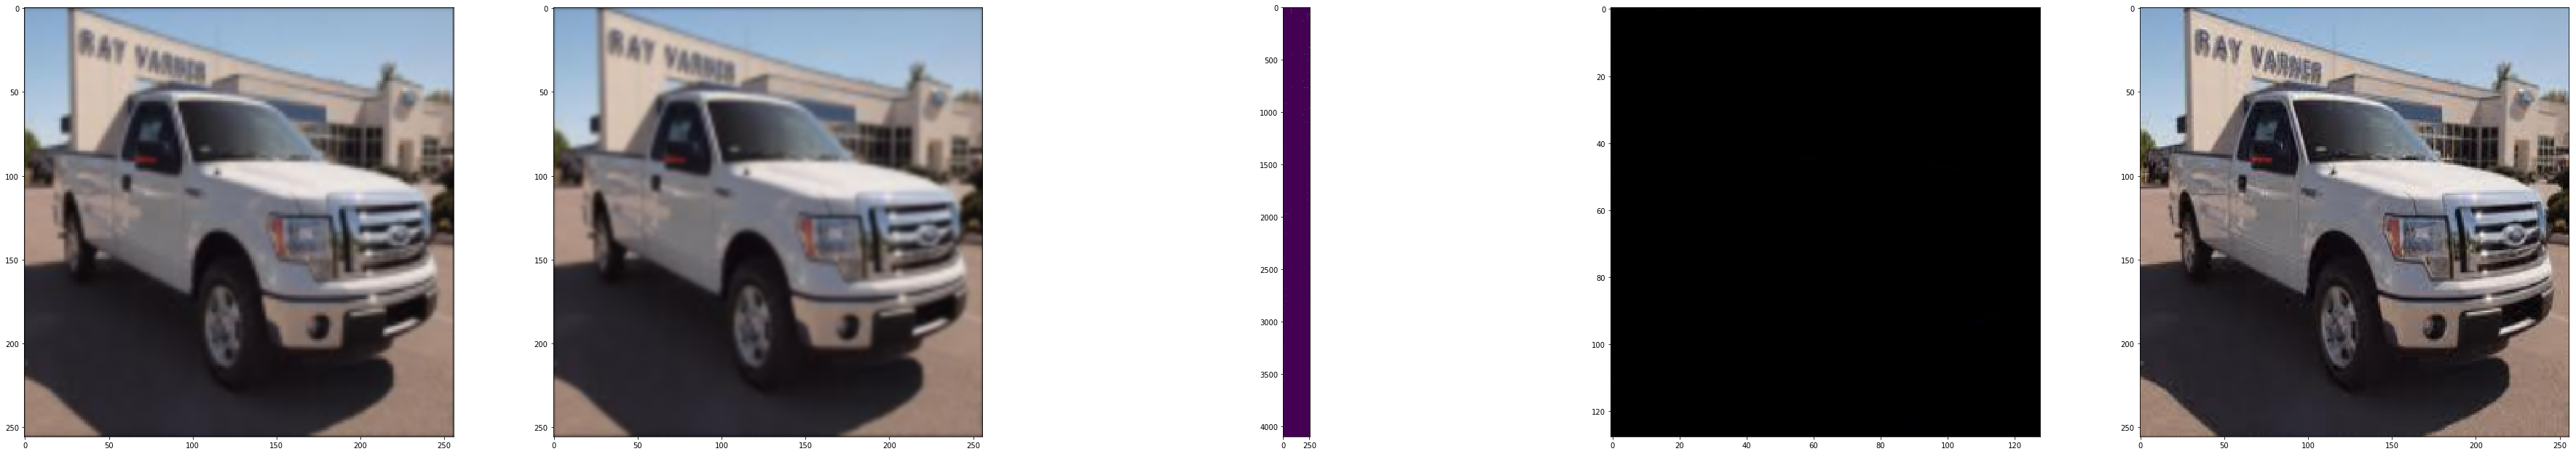

In [ ]:
plt.figure(figsize=(128,128))
i=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index])
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index],interpolation='bicubic')
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(encoded_imgs[image_index].reshape((64*64,256)))
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(sr1[image_index])
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_n[image_index])
plt.show()